<a href="https://colab.research.google.com/github/jaindeepali/backtest/blob/main/Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Currently uses European option model

**ToDo:**
1. Model the effects of
  - dividends
  - earnings calls
2. Implement Turtle strategy from https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2435821
3. Improve volatility estimate with regression

In [ ]:
#@title Imports
import matplotlib.pyplot as plt
from collections import namedtuple
import datetime as dt
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm

In [ ]:
#@title Fetch Data
symbol = "SPY" #@param
stock = yf.Ticker(symbol)
hist = stock.history(period="max")
hist['Close -1'] = hist['Close'].shift(1)
hist["Volatility"] = np.log(hist["Close"]) - np.log(hist["Close -1"])
measurement_n = 30
hist["Realized Volatility"] = np.sqrt(252.0)*hist["Volatility"].rolling(measurement_n).std()
# hist["VolatilitySq"] = np.square(hist["Volatility"] - hist["Volatility"].rolling(90).mean())/89.0
# hist["Realized Volatility2"] = np.sqrt((252.0)*hist["VolatilitySq"].rolling(measurement_n).sum())
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Close -1,Volatility,Realized Volatility
Date,,,,,,,,,,,
2024-04-29 00:00:00-04:00,510.089996,510.750000,507.250000,510.059998,46415400,0.0,0.0,0.0,508.260010,0.003535,0.114948
2024-04-30 00:00:00-04:00,508.559998,509.559998,501.980011,501.980011,77483600,0.0,0.0,0.0,510.059998,-0.015968,0.122435
2024-05-01 00:00:00-04:00,501.380005,508.190002,499.869995,500.350006,80242800,0.0,0.0,0.0,501.980011,-0.003252,0.121177
2024-05-02 00:00:00-04:00,504.149994,505.890015,499.549988,505.029999,62550200,0.0,0.0,0.0,500.350006,0.009310,0.121253
2024-05-03 00:00:00-04:00,511.160004,512.549988,508.559998,511.290009,72529927,0.0,0.0,0.0,505.029999,0.012319,0.126729


In [ ]:
#@title Option Pricing Model
r = 0.0212 # RISK_FREE_INTEREST_RATE
last_date = hist.index[-1].strftime('%Y-%m-%d')
exp_dates = stock.options
exp_days = 0
exp_date = last_date
for exp_date in exp_dates:
  delta = dt.datetime.strptime(exp_date, '%Y-%m-%d') - dt.datetime.strptime(last_date, '%Y-%m-%d')
  exp_days = delta.days
  if exp_days > 30:
    break

def put_premium(price, strike, volatility, t):
  t = t/252.0
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
  return norm.cdf(-d2)*strike*np.exp(-r*t) - price*norm.cdf(-d1)

def call_premium(price, strike, volatility, t):
  t = t/252.0
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
  return price*norm.cdf(d1) - norm.cdf(d2)*strike*np.exp(-r*t)

price = hist['Close'][-1]
volatility = hist['Realized Volatility'][-1]
real_options = stock.option_chain(exp_date)

print(f'expiration days: {exp_days}, current price: {price}, vol: {volatility}')

put_rows = real_options.puts.sample(n=3)
call_rows = real_options.puts.sample(n=3)

for i, row in put_rows.iterrows():
  strike = row["strike"]
  p = put_premium(price, strike, volatility, exp_days)
  rp = row['lastPrice']
  iv = row['impliedVolatility']
  print(f'\nstrike: {strike}')
  print(f'est put premium: {p}, real put premium: {rp}, real implied volatility: {iv}')

for i, row in call_rows.iterrows():
  strike = row["strike"]
  p = put_premium(price, strike, volatility, exp_days)
  rp = row['lastPrice']
  iv = row['impliedVolatility']
  print(f'\nstrike: {strike}')
  print(f'est call premium: {p}, real call premium: {rp}, real implied volatility: {iv}')

expiration days: 35, current price: 511.2900085449219, vol: 0.12672908821181392

strike: 483.0
est put premium: 1.1425490063499524, real put premium: 1.18, real implied volatility: 0.14905636108398437

strike: 503.0
est put premium: 5.441034367841809, real put premium: 3.86, real implied volatility: 0.11731839721679688

strike: 475.0
est put premium: 0.5136620549956099, real put premium: 0.74, real implied volatility: 0.1624229266357422

strike: 455.0
est call premium: 0.041256472863355764, real call premium: 0.33, real implied volatility: 0.20142400146484374

strike: 512.5
est call premium: 9.482201929185408, real call premium: 6.96, real implied volatility: 0.10138838073730468

strike: 492.0
est call premium: 2.4785354917259923, real call premium: 1.92, real implied volatility: 0.13471324279785157


In [ ]:
#@title Stock/Option Strategy Class

SHORT_TERM_TAX_RATE = 0.35
LONG_TERM_TAX_RATE = 0.25
BROKER_COMMISION_PER_TRADE = 0.65

from dataclasses import dataclass

@dataclass
class Position:
  eq_type: str = "STOCK"
  status: str = "BOUGHT"
  start: int = 0
  size: int = 0
  expiration: int = -1
  collateral: int = 0
  start_price: int = 0
  strike: int = -1

class Strategy():

  def __init__(self,
               symbol="SPY",
               approx_start_date='2005-01-01',
               starting_capital=10000,
               include_options_in_equity=False):
    self._symbol = symbol
    self._approx_start_date = np.datetime64(approx_start_date)
    self._starting_capital = starting_capital
    self._include_options_in_equity = include_options_in_equity
    self._active_positions = []
    self._portfolio = {}
    self.fetch_data()
    self._step = self._start
    self.reset(self._starting_capital)

  def fetch_data(self):
    stock = yf.Ticker(self._symbol)
    self._hist = stock.history(period="max")
    self._hist.index = self._hist.index.tz_convert(None)
    self._hist['Close -1'] = self._hist['Close'].shift(1)
    self._hist["Volatility"] = np.log(self._hist["Close"]) - np.log(self._hist["Close -1"])
    measurement_n = 30
    self._hist["Realized Volatility"] = np.sqrt(252.0)*self._hist["Volatility"].rolling(measurement_n).std()
    n = len(self._hist[self._hist.index <= self._approx_start_date].index)
    offset = max(31, n)
    first_day = dt.datetime.weekday(self._hist.index[offset])
    self._start = offset + (4-first_day)%7
    self._portfolio['Cash'] = [self._starting_capital]*len(self._hist)
    self._portfolio['Equity'] = [0]*len(self._hist)

  def reset(self, starting_capital=0):
    self._starting_capital = starting_capital
    self._portfolio['Cash'] = [self._starting_capital]*len(self._hist)
    self._portfolio['Equity'] = [0]*len(self._hist)
    self._active_positions = []
    self._step = self._start

  def run(self):
    for i in range(self._start, len(self._hist)):
      self._step = i
      self._portfolio['Cash'][i] = self._portfolio['Cash'][i-1]
      for position in self._active_positions:
        if position.expiration > 0:
          position.expiration -= 1
      self._resolve_expired_positions()
      self._create_new_positions()
      self._calculate_equity()

  def _resolve_expired_positions(self):
      for position in self._active_positions:
        if position.expiration == 0:
          tax_rate = SHORT_TERM_TAX_RATE if (self._step - position.start) < 365 else LONG_TERM_TAX_RATE
          if position.eq_type == "STOCK":
            price = self._hist['Close'][self._step]
            tax = position.size * (price - position.start_price) * tax_rate
            cash = (position.size * price) - tax - BROKER_COMMISION_PER_TRADE
            self._portfolio['Cash'][self._step] += cash
          elif position.eq_type in ["CALL", "PUT"]:
            position.status = "SOLD" if position.status == "BOUGHT" else "BOUGHT"
            self._trade_option(
                is_new_position=False,
                position=position)
      self._active_positions = [position for position in self._active_positions if position.expiration != 0]

  def _create_new_positions(self):
    raise NotImplementedError("Implemented in the base class")

  def _buy_stock(self, cash_amount=None, size=None):
    if (cash_amount is None) and (size is None):
      print("Both cash amount and size cannot be None.")
      return

    if (cash_amount is not None) and (size is not None):
      print("Both cash amount and size cannot be set.")
      return

    price = self._hist['Close'][self._step]
    if size == None:
      size = int(cash_amount / price)
    stock_position = Position(eq_type = "STOCK",
                              status = "BOUGHT",
                              start = self._step,
                              size = size,
                              expiration = len(self._hist)-30-self._step,
                              collateral = 0,
                              start_price = price,
                              strike = -1)
    cost = size * price + BROKER_COMMISION_PER_TRADE
    if self._portfolio['Cash'][self._step] > cost:
      self._portfolio['Cash'][self._step] -= cost
      self._active_positions.append(stock_position)

  def _trade_option(self,
                    is_new_position,
                    position):
    price = self._hist['Close'][self._step]
    volatility = self._hist['Realized Volatility'][self._step]
    if position.eq_type == "CALL":
      premium = call_premium(price, position.strike, volatility, position.expiration)
    elif position.eq_type == "PUT":
      premium = put_premium(price, position.strike, volatility, position.expiration)

    if position.status == "BOUGHT":
      premium = -1*premium

    tax = 0
    if is_new_position:
      tax_rate = SHORT_TERM_TAX_RATE if position.expiration < 365 else LONG_TERM_TAX_RATE
    else:
      tax_rate = SHORT_TERM_TAX_RATE if (self._step - position.start) < 365 else LONG_TERM_TAX_RATE

    tax = position.size * premium * tax_rate

    cash = position.size * premium - BROKER_COMMISION_PER_TRADE - tax
    remaining_cash = self._portfolio['Cash'][self._step] + cash

    # Collateral check?
    # if is_new_position and (position.status == "SOLD"):
    #   if position.eq_type == "PUT":
    #     position.collateral = position.strike * position.size
    #     if remaining_cash < position.collateral:
    #       print("Not enough collateral for this trade.")
    #       return
    #   if position.eq_type == "CALL":
    #     available_stocks = 0
    #     for pos in self._active_positions:
    #       if pos.eq_type == "STOCK":
    #         available_stocks += pos.size
    #     if available_stocks < position.size:
    #       print("Not enough stocks for this trade.")
    #       return

    if remaining_cash > 0:
      self._portfolio['Cash'][self._step] += cash
      if is_new_position:
        position.start_price = premium if position.status == "SOLD" else -1*premium
        self._active_positions.append(position)

  def _calculate_equity(self):
    total_equity = 0
    for position in self._active_positions:
      if position.eq_type == "STOCK":
        price = self._hist['Close'][self._step]
        total_equity += (position.size * price)
      elif self._include_options_in_equity and (position.eq_type in ["CALL", "PUT"]) and position.status == "BOUGHT":
        price = self._hist['Close'][self._step]
        volatility = self._hist['Realized Volatility'][self._step]
        if position.eq_type == "CALL":
          premium = call_premium(
              price, position.strike, volatility, position.expiration)
        elif position.eq_type == "PUT":
          premium = put_premium(
              price, position.strike, volatility, position.expiration)
        total_equity += (position.size * premium)
    self._portfolio['Equity'][self._step] = total_equity

  def report(self, plot=False):
    start_cash = self._portfolio['Cash'][self._start]
    end_cash = self._portfolio['Cash'][-1]
    start_eq = self._portfolio['Equity'][self._start]
    end_eq = self._portfolio['Equity'][-1]

    print(f'\n Account value on {self._hist.index[self._start]}:')
    print(f'Capital in Cash: {start_cash}')
    print(f'Capital in Equity: {start_eq}')
    print(f'\n Account value on {self._hist.index[-1]}:')
    print(f'Capital in Cash: {end_cash}')
    print(f'Capital in Stocks: {end_eq}')
    if plot:
      # plt.title(self._name)
      plt.stackplot(self._hist.index[self._start:], [self._portfolio['Cash'][self._start:], self._portfolio['Equity'][self._start:]], labels=['Cash', 'Equity'])
      plt.legend()



 Account value on 2005-01-07 05:00:00:
Capital in Cash: 68.22274932861365
Capital in Equity: 9931.127250671387

 Account value on 2024-05-03 04:00:00:
Capital in Cash: 49850.16405601501
Capital in Stocks: 0


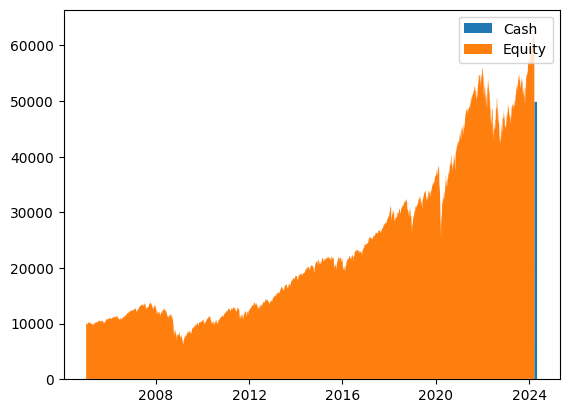

In [ ]:
#@title Buy and Hold

class BuyAndHold(Strategy):
  def _create_new_positions(self):
    if self._step == self._start:
      self._buy_stock(cash_amount=self._portfolio['Cash'][self._step])


bnh_strategy = BuyAndHold()
bnh_strategy.run()
bnh_strategy.report(plot=True)


 Account value on 2005-01-07 05:00:00:
Capital in Cash: 9506.897409057618
Capital in Equity: 492.4525909423828

 Account value on 2024-05-03 04:00:00:
Capital in Cash: 49236.01142692555
Capital in Stocks: 511.2900085449219


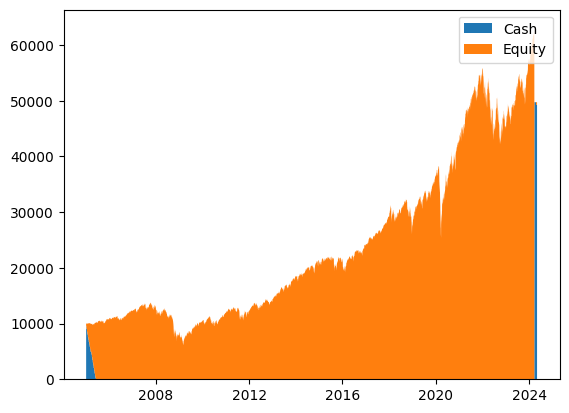

In [ ]:
#@title Weekly Dollar Cost Average

class WeeklyDCA(Strategy):
  def _create_new_positions(self):
    cash = self._portfolio['Cash'][self._step]
    if self._step == self._start:
      self._installment = cash/20.0

    if dt.datetime.weekday(hist.index[self._step]) == 4 and cash > 0:
      installment = min(cash, self._installment)
      self._buy_stock(cash_amount=installment)

wdca_strategy = WeeklyDCA()
wdca_strategy.run()
wdca_strategy.report(plot=True)

<ipython-input-58-c514f085d92e>:99: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
<ipython-input-58-c514f085d92e>:100: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))



 Account value on 2005-01-07 05:00:00:
Capital in Cash: 10024.875002185061
Capital in Equity: 0

 Account value on 2024-05-03 04:00:00:
Capital in Cash: 35338.840399585824
Capital in Stocks: 0


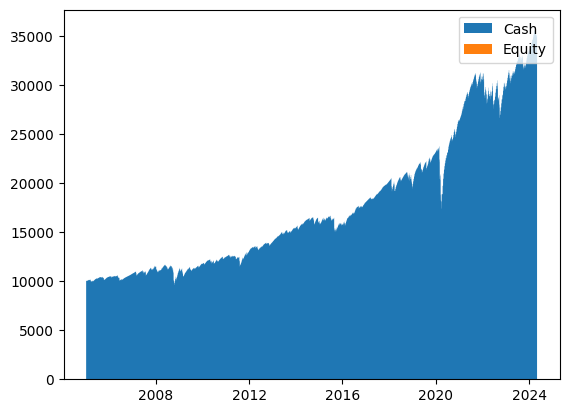

In [ ]:
#@title Sell Puts
class SellingPuts(Strategy):
  def __init__(self, put_strike_percentage=0.01, size=100, **kwargs):
    self._put_strike_percentage = put_strike_percentage
    self._size = size
    super().__init__(**kwargs)

  def _create_new_positions(self):
    if dt.datetime.weekday(hist.index[self._step]) == 4:
      price = self._hist['Close'][self._step]
      volatility = self._hist['Realized Volatility'][self._step]
      strike = price*(1 - volatility*self._put_strike_percentage)
      position = Position(eq_type = "PUT",
                          status = "SOLD",
                          start = self._step,
                          size = self._size,
                          expiration = 7,
                          collateral = 0,
                          start_price = -1,
                          strike = strike)
      self._trade_option(is_new_position=True, position=position)


ps_strategy = SellingPuts()
ps_strategy.run()
ps_strategy.report(plot=True)

<ipython-input-58-c514f085d92e>:105: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
<ipython-input-58-c514f085d92e>:106: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))



 Account value on 2005-01-07 05:00:00:
Capital in Cash: 1804.4697000442607
Capital in Equity: 8207.542419433594

 Account value on 2024-05-03 04:00:00:
Capital in Cash: 48289.1762119381
Capital in Stocks: 0


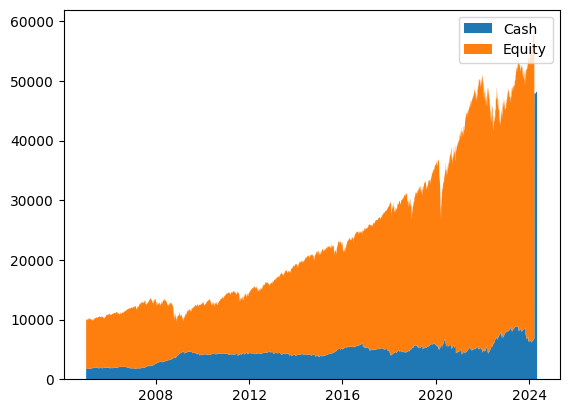

In [ ]:
#@title Selling Calls

class SellingCalls(Strategy):
  def __init__(self, call_strike_percentage=0.1, size=100, **kwargs):
    self._call_strike_percentage = call_strike_percentage
    self._size = size
    super().__init__(**kwargs)

  def _create_new_positions(self):
    if self._step == self._start:
      self._buy_stock(size=self._size)

    if dt.datetime.weekday(hist.index[self._step]) == 4:
      price = self._hist['Close'][self._step]
      volatility = self._hist['Realized Volatility'][self._step]
      strike = price*(1 + volatility*self._call_strike_percentage)
      position = Position(eq_type = "CALL",
                          status = "SOLD",
                          start = self._step,
                          size = self._size,
                          expiration = 7,
                          collateral = 0,
                          start_price = -1,
                          strike = strike)
      self._trade_option(is_new_position=True, position=position)


sc_strategy = SellingCalls()
sc_strategy.run()
sc_strategy.report(plot=True)

Risked 1999.9970898327945 for premium 499.35658749674286. Ratio p/r : 0.24967865705169126.
Risked 1999.897659902891 for premium 499.98635919185944. Ratio p/r : 0.25000597241367706.
Risked 1999.5024285591517 for premium 504.0297913473882. Ratio p/r : 0.2520776089832478.
Risked 1999.5378737799047 for premium 501.8620351449391. Ratio p/r : 0.25098901187414097.
Risked 1999.9018550912601 for premium 504.659334442743. Ratio p/r : 0.25234205026511874.
Risked 1999.684944665674 for premium 506.7421036330971. Ratio p/r : 0.25341097105565247.
Risked 1999.8137061592122 for premium 503.0418131721782. Ratio p/r : 0.2515443371664387.
Risked 1999.557301242567 for premium 509.26900207855704. Ratio p/r : 0.2546908767066023.
Risked 1999.254262950977 for premium 506.15587755886156. Ratio p/r : 0.2531723387758373.
Risked 1999.598834518465 for premium 509.36456284572813. Ratio p/r : 0.25473337654169576.
Risked 1999.7650100268038 for premium 511.2485191616471. Ratio p/r : 0.2556542976791031.
Risked 1999.6578

<ipython-input-58-c514f085d92e>:105: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
<ipython-input-58-c514f085d92e>:106: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
<ipython-input-58-c514f085d92e>:99: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
<ipython-input-58-c514f085d92e>:100: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))


Risked 1999.8805483255173 for premium 504.453364269599. Ratio p/r : 0.2522417474843552.
Risked 1999.6513810941565 for premium 508.9172565931499. Ratio p/r : 0.2545029905736288.
Risked 1999.2992852242348 for premium 507.6979897466755. Ratio p/r : 0.25393796391505924.
Risked 1999.9520447342807 for premium 514.4561374684017. Ratio p/r : 0.25723423660228506.
Risked 1998.9128082314644 for premium 519.5331869020257. Ratio p/r : 0.2599078783039477.
Risked 1999.0289844389126 for premium 519.4752800938189. Ratio p/r : 0.2598638059465782.
Risked 1999.5911519554015 for premium 519.5884345313369. Ratio p/r : 0.25984733630333934.
Risked 1998.9631805942151 for premium 516.6477561914229. Ratio p/r : 0.25845786516079966.
Risked 1999.9755545120927 for premium 514.6519907615498. Ratio p/r : 0.25732914064897283.
Risked 1999.4309409301502 for premium 504.6409760396818. Ratio p/r : 0.25239230108388694.
Risked 1999.3939932221067 for premium 496.919923882085. Ratio p/r : 0.24853526896981312.
Risked 1999.9907

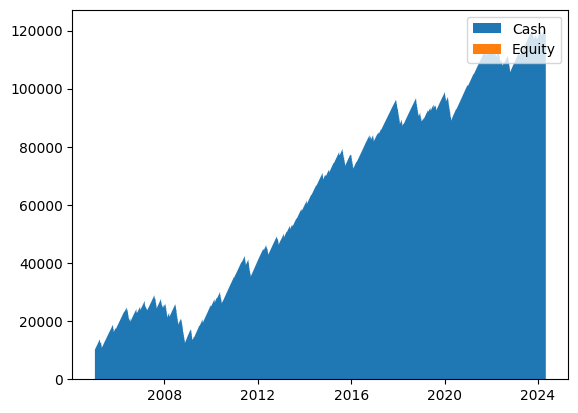

In [ ]:
#@title Iron Condor

class IronCondor(Strategy):
  def __init__(self,
               call_short_strike_percentage=0.6,
               call_long_strike_percentage=0.7,
               put_short_strike_percentage=0.2,
               put_long_strike_percentage=0.3,
               max_percentage_capital_risk=0.5,
               max_dollar_capital_risk=2000,
               expiration=30.0,
               **kwargs):
    self._call_short_strike_percentage = call_short_strike_percentage
    self._call_long_strike_percentage = call_long_strike_percentage
    self._put_short_strike_percentage = put_short_strike_percentage
    self._put_long_strike_percentage = put_long_strike_percentage
    self._max_percentage_capital_risk = max_percentage_capital_risk
    self._max_dollar_capital_risk = max_dollar_capital_risk
    self._expiration = expiration
    super().__init__(**kwargs)

  def _create_new_positions(self):
    if dt.datetime.weekday(hist.index[self._step]) == 4:
      price = self._hist['Close'][self._step]
      volatility = self._hist['Realized Volatility'][self._step]
      call_short_strike = price*(1 + volatility*self._call_short_strike_percentage)
      call_long_strike = price*(1 + volatility*self._call_long_strike_percentage)
      put_short_strike = price*(1 - volatility*self._put_short_strike_percentage)
      put_long_strike = price*(1 - volatility*self._put_long_strike_percentage)

      risk_capital = min(self._portfolio['Cash'][self._step]*self._max_percentage_capital_risk, self._max_dollar_capital_risk)
      risk = call_long_strike - call_short_strike
      # print(risk, call_long_strike, call_short_strike, volatility)
      size = int(risk_capital/(risk))
      premium = 0

      position = Position(eq_type = "CALL",
                          status = "SOLD",
                          start = self._step,
                          size = size,
                          expiration = self._expiration,
                          collateral = 0,
                          start_price = -1,
                          strike = call_short_strike)
      self._trade_option(is_new_position=True, position=position)
      premium += position.start_price
      position = Position(eq_type = "CALL",
                          status = "BOUGHT",
                          start = self._step,
                          size = size,
                          expiration = self._expiration,
                          collateral = 0,
                          start_price = -1,
                          strike = call_long_strike)
      self._trade_option(is_new_position=True, position=position)
      premium -= position.start_price
      position = Position(eq_type = "PUT",
                          status = "SOLD",
                          start = self._step,
                          size = size,
                          expiration = self._expiration,
                          collateral = 0,
                          start_price = -1,
                          strike = put_short_strike)
      self._trade_option(is_new_position=True, position=position)
      premium += position.start_price
      position = Position(eq_type = "PUT",
                          status = "BOUGHT",
                          start = self._step,
                          size = size,
                          expiration = self._expiration,
                          collateral = 0,
                          start_price = -1,
                          strike = put_long_strike)
      self._trade_option(is_new_position=True, position=position)
      premium -= position.start_price

      premium = premium*size
      risked = risk*size
      print(f"Risked {risked} for premium {premium}. Ratio p/r : {premium/risked}.")

ic_strategy = IronCondor()
ic_strategy.run()
ic_strategy.report(plot=True)

# from types import SimpleNamespace
# r =  0.0212 #@param
# call_short_strike_percentage = 0.6 #@param
# call_long_strike_percentage = 0.7 #@param
# put_short_strike_percentage = 0.2 #@param
# put_long_strike_percentage = 0.3 #@param
# starting_capital = 10000 #@param
# starting_stock_capital_percentage = 0.0 #@param
# max_percentage_capital_risk = 0.5 #@param
# max_dollar_capital_risk = 1000 #@param
# broker_commision_per_trade = 0.65 #@param
# expiration_days = [4] #@param

# def put_premium(price, strike, volatility, t=30.0):
#   t = t/252.0
#   d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
#   d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
#   return norm.cdf(-d2)*strike*np.exp(-r*t) - price*norm.cdf(-d1)

# def call_premium(price, strike, volatility, t=30.0):
#   t = t/252.0
#   d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
#   d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
#   return price*norm.cdf(d1) - norm.cdf(d2)*strike*np.exp(-r*t)

# def create_position(i, capital):
#   price = hist['Close'][i]
#   volatility = hist['Realized Volatility'][i]
#   contracts = []
#   credit = 0
#   a = price*(1 - volatility*put_long_strike_percentage)
#   credit -= put_premium(price, a, volatility)
#   b = price*(1 - volatility*put_short_strike_percentage)
#   credit += put_premium(price, b, volatility)
#   c = price*(1 + volatility*call_short_strike_percentage)
#   credit += call_premium(price, c, volatility)
#   d = price*(1 + volatility*call_long_strike_percentage)
#   credit -= call_premium(price, d, volatility)
#   risk = d-c
#   size = capital/(risk*100)
#   size = size.astype(int)
#   risked = risk*size*100
#   premium = credit*100*size
#   position = SimpleNamespace(
#       name='iron_condor',
#       strikes=[a, b, c, d],
#       expiration=30.0,
#       resolved=False,
#       risked=risked,
#       premium=premium,
#       size=size)

#   return premium, position, risked

# def resolve_position(position, i):
#   price = hist['Close'][i]
#   a, b, c, d = position.strikes
#   if price < a:
#     cost = (b-a)
#   elif price < b:
#     cost = (b-price)
#   elif price < c:
#     cost = 0
#   elif price < d:
#     cost = (price-c)
#   elif price >=d:
#     cost = (d-c)
#   position.resolved = True
#   return cost*100*position.size
# start = is_strategy._start
# ns = int((starting_capital*starting_stock_capital_percentage) / (hist['Close'][start]))
# stock_value = [ns * hist['Close'][start]]
# cash = [starting_capital - stock_value[0]]
# collateral = [0]
# active_positions = []
# trades = []
# for i in range(start, len(hist)):
#   cash.append(cash[-1])
#   collateral.append(collateral[-1])
#   stock_value.append(ns * hist['Close'][i])
#   for position in active_positions:
#     position.expiration -= 1
#     if position.expiration == 0 and not position.resolved:
#       cost = resolve_position(position, i)
#       position.resolved = True
#       loss = cost*(1 - SHORT_TERM_TAX_RATE)
#       trades.append(position.premium - cost)
#       cash[-1] -= loss
#       cash[-1] += position.risked
#       collateral[-1] -= position.risked
#   active_positions = [position for position in active_positions if position.resolved == False]
#   if dt.datetime.weekday(hist.index[i]) in expiration_days:
#     risk_capital = min(cash[-1]*max_percentage_capital_risk, max_dollar_capital_risk)
#     premium, position, risked = create_position(i, risk_capital)
#     print("Risked: ", risked)
#     print("Premium: ", premium)
#     print("Reward/Risk: ", premium/risked)
#     cash[-1] += premium*(1 - SHORT_TERM_TAX_RATE)
#     cash[-1] -= risked
#     collateral[-1] += risked
#     active_positions.append(position)

# cash = np.array(cash) + np.array(collateral)
# print(f'Capital in Cash: {starting_capital}')
# print(f'Capital in Stocks: {0}')
# print(f'\n Account value on {hist.index[-1]}:')
# print(f'Capital in Cash: {cash[-1]}')
# print(f'Capital in Stocks: {stock_value[-1]}')
# n =len(hist.index[start:])
# plt.stackplot(hist.index[start:], [cash[1:], stock_value[1:]], labels=['Cash', 'Stocks'])
# plt.legend()
# ic_cash = cash
# ic_stock_value = stock_value

<ipython-input-58-c514f085d92e>:99: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
<ipython-input-58-c514f085d92e>:100: RuntimeWarning: divide by zero encountered in scalar divide
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))



 Account value on 2005-01-07 05:00:00:
Capital in Cash: 10271.875289071213
Capital in Equity: 0

 Account value on 2024-05-03 04:00:00:
Capital in Cash: 121552.14485290753
Capital in Stocks: 0


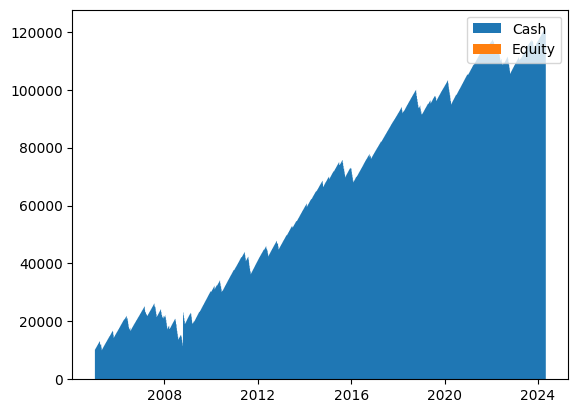

In [ ]:
#@title Bull Put Spread

class BullPutSpread(Strategy):
  def __init__(self,
               put_short_strike_percentage=0.2,
               put_long_strike_percentage=0.3,
               max_percentage_capital_risk=0.5,
               max_dollar_capital_risk=2000,
               expiration=30.0,
               **kwargs):
    self._put_short_strike_percentage = put_short_strike_percentage
    self._put_long_strike_percentage = put_long_strike_percentage
    self._max_percentage_capital_risk = max_percentage_capital_risk
    self._max_dollar_capital_risk = max_dollar_capital_risk
    self._expiration = expiration
    super().__init__(**kwargs)

  def _create_new_positions(self):
    if dt.datetime.weekday(hist.index[self._step]) == 4:
      price = self._hist['Close'][self._step]
      volatility = self._hist['Realized Volatility'][self._step]
      put_short_strike = price*(1 - volatility*self._put_short_strike_percentage)
      put_long_strike = price*(1 - volatility*self._put_long_strike_percentage)

      risk_capital = min(self._portfolio['Cash'][self._step]*self._max_percentage_capital_risk, self._max_dollar_capital_risk)
      risk = put_short_strike - put_long_strike
      size = int(risk_capital/(risk))
      premium = 0

      position = Position(eq_type = "PUT",
                          status = "SOLD",
                          start = self._step,
                          size = size,
                          expiration = self._expiration,
                          collateral = 0,
                          start_price = -1,
                          strike = put_short_strike)
      self._trade_option(is_new_position=True, position=position)
      premium += position.start_price
      position = Position(eq_type = "PUT",
                          status = "BOUGHT",
                          start = self._step,
                          size = size,
                          expiration = self._expiration,
                          collateral = 0,
                          start_price = -1,
                          strike = put_long_strike)
      self._trade_option(is_new_position=True, position=position)
      premium -= position.start_price

      # premium = premium*size
      # risked = risk*size
      # print(f"Risked {risked} for premium {premium}. Ratio p/r : {premium/risked}.")

bps_strategy = BullPutSpread()
bps_strategy.run()
bps_strategy.report(plot=True)


# r =  0.0212 #@param
# short_strike_percentage = 0.2 #@param
# long_strike_percentage = 0.3 #@param
# starting_capital = capital_in #@param
# starting_stock_capital_percentage = 0.0 #@param
# max_percentage_capital_risk = 0.5 #@param
# max_dollar_capital_risk =  1000#@param
# broker_commision_per_trade = 0.65 #@param
# expiration_days = [4] #@param

# def put_premium(price, strike, volatility, t=30.0):
#   t = t/252.0
#   d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
#   d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
#   return norm.cdf(-d2)*strike*np.exp(-r*t) - price*norm.cdf(-d1)

# def call_premium(price, strike, volatility, t=30.0):
#   t = t/252.0
#   d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
#   d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
#   return price*norm.cdf(d1) - norm.cdf(d2)*strike*np.exp(-r*t)

# def create_position(i, capital):
#   price = hist['Close'][i]
#   volatility = hist['Realized Volatility'][i]
#   contracts = []
#   credit = 0
#   a = price*(1 - volatility*long_strike_percentage)
#   credit -= put_premium(price, a, volatility)
#   b = price*(1 - volatility*short_strike_percentage)
#   credit += put_premium(price, b, volatility)
#   risk = b-a
#   size = capital/(risk*100)
#   size = size.astype(int)
#   risked = risk*size*100
#   premium = credit*100*size
#   position = SimpleNamespace(
#       name='bull_put_spread',
#       strikes=[a, b],
#       expiration=30.0,
#       resolved=False,
#       risked=risked,
#       premium=premium,
#       size=size)

#   return position

# def resolve_position(position, i):
#   price = hist['Close'][i]
#   a, b = position.strikes
#   if price < a:
#     cost = (b-a)
#   elif price < b:
#     cost = (b-price)
#   elif price >=b:
#     cost = 0
#   position.resolved = True
#   return cost*100*position.size

# ns = int((starting_capital*starting_stock_capital_percentage) / (hist['Close'][start]))
# stock_value = [ns * hist['Close'][start]]
# cash = [starting_capital - stock_value[0]]
# collateral = [0]
# active_positions = []
# trades = []
# for i in range(start, len(hist)):
#   cash.append(cash[-1])
#   collateral.append(collateral[-1])
#   stock_value.append(ns * hist['Close'][i])
#   for position in active_positions:
#     position.expiration -= 1
#     if position.expiration == 0 and not position.resolved:
#       cost = resolve_position(position, i)
#       position.resolved = True
#       loss = cost*(1 - short_term_tax_rate)
#       trades.append(position.premium - cost)
#       cash[-1] -= loss
#       cash[-1] += position.risked
#       collateral[-1] -= position.risked
#   active_positions = [position for position in active_positions if position.resolved == False]
#   if dt.datetime.weekday(hist.index[i]) in expiration_days:
#     risk_capital = min(cash[-1]*max_percentage_capital_risk, max_dollar_capital_risk)
#     position = create_position(i, risk_capital)
#     # print("Risked: ", position.risked)
#     # print("Premium: ", position.premium)
#     # print("Reward/Risk: ", position.premium/position.risked)
#     cash[-1] += position.premium*(1 - short_term_tax_rate)
#     cash[-1] -= position.risked
#     collateral[-1] += position.risked
#     active_positions.append(position)

# cash = np.array(cash) + np.array(collateral)
# print(f'Capital in Cash: {starting_capital}')
# print(f'Capital in Stocks: {0}')
# print(f'\n Account value on {hist.index[-1]}:')
# print(f'Capital in Cash: {cash[-1]}')
# print(f'Capital in Stocks: {stock_value[-1]}')
# n =len(hist.index[start:])
# plt.stackplot(hist.index[start:], [cash[1:], stock_value[1:]], labels=['Cash', 'Stocks'])
# plt.legend()
# bps_cash = cash
# bps_stock_value = stock_value

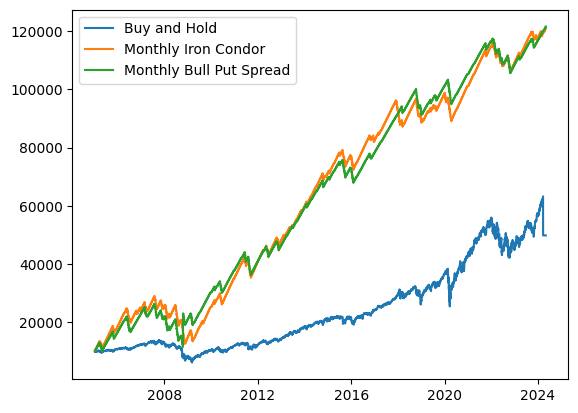

In [ ]:
#@title Comparing Option Strategies
def plot_all(st, label):
  plt.plot(st._hist.index[st._start:], np.array(st._portfolio['Cash'][st._start:]) + np.array(st._portfolio['Equity'][st._start:]), label=label)

plot_all(bnh_strategy, "Buy and Hold")
# plot_all(wdca_strategy, "Weekly DCA")
# plot_all(ps_strategy, "Weekly Sell Puts")
# plot_all(sc_strategy, "Weekly Sell Calls")
plot_all(ic_strategy, "Monthly Iron Condor")
plot_all(bps_strategy, "Monthly Bull Put Spread")

plt.legend()

#Scratch

Capital in Cash: 10000.0
Capital in Stocks: 0

 Account value on 2021-09-27 00:00:00:
Capital in Cash: 38818.45163384011
Capital in Stocks: 0.0


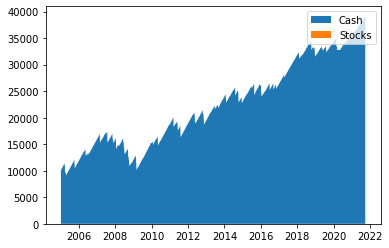

In [ ]:
#@title Vertical Spread [Incomplete mew impl]

# class VerticalSpread(Strategy):
#   def __init__(self,
#                short_strike_percentage=0.2,
#                long_strike_percentage=0.3,
#                max_percentage_capital_risk=0.5,
#                max_dollar_capital_risk=1000,
#                expiration=30.0,
#                **kwargs):
#     self._short_strike_percentage = short_strike_percentage
#     self._long_strike_percentage = long_strike_percentage
#     self._max_percentage_capital_risk = max_percentage_capital_risk
#     self._max_dollar_capital_risk = max_dollar_capital_risk
#     self._expiration = expiration
#     super().__init__(**kwargs)

#   def _create_new_positions(self):
#     if dt.datetime.weekday(hist.index[self._step]) == 4:
#       price = self._hist['Close'][self._step]
#       volatility = self._hist['Realized Volatility'][self._step]

#       #Put spread
#       put_short_strike = price*(1 - volatility*self._short_strike_percentage)
#       put_long_strike = price*(1 - volatility*self._long_strike_percentage)

#       risk_capital = min(self._portfolio['Cash'][self._step]*self._max_percentage_capital_risk, self._max_dollar_capital_risk)
#       risk = put_short_strike - put_long_strike
#       size = int(risk_capital/(risk))
#       premium = 0

#       position = Position(eq_type = "PUT",
#                           status = "SOLD",
#                           start = self._step,
#                           size = size,
#                           expiration = self._expiration,
#                           collateral = 0,
#                           start_price = -1,
#                           strike = put_short_strike)
#       self._trade_option(is_new_position=True, position=position)
#       premium += position.start_price
#       position = Position(eq_type = "PUT",
#                           status = "BOUGHT",
#                           start = self._step,
#                           size = size,
#                           expiration = self._expiration,
#                           collateral = 0,
#                           start_price = -1,
#                           strike = put_long_strike)
#       self._trade_option(is_new_position=True, position=position)
#       premium -= position.start_price

#       # premium = premium*size
#       # risked = risk*size
#       # print(f"Risked {risked} for premium {premium}. Ratio p/r : {premium/risked}.")

# vs_strategy = VerticalSpread()
# vs_strategy.run()
# vs_strategy.report(plot=True)

r =  0.0212 #@param
short_strike_percentage = 0.2 #@param
long_strike_percentage = 0.3 #@param
starting_capital = capital_in #@param
starting_stock_capital_percentage = 0.0 #@param
max_percentage_capital_risk = 0.5 #@param
max_dollar_capital_risk =  1000#@param
broker_commision_per_trade = 0.65 #@param
expiration_days = [4] #@param

def put_premium(price, strike, volatility, t=30.0):
  t = t/252.0
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
  return norm.cdf(-d2)*strike*np.exp(-r*t) - price*norm.cdf(-d1)

def call_premium(price, strike, volatility, t=30.0):
  t = t/252.0
  d1 = (np.log(price/strike) + (r + (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
  d2 = (np.log(price/strike) + (r - (volatility**2)/2.0)*t)/(volatility*np.sqrt(t))
  return price*norm.cdf(d1) - norm.cdf(d2)*strike*np.exp(-r*t)

def create_put_spread(i, capital):
  price = hist['Close'][i]
  volatility = hist['Realized Volatility'][i]
  credit = 0
  a = price*(1 - volatility*long_strike_percentage)
  credit -= put_premium(price, a, volatility)
  b = price*(1 - volatility*short_strike_percentage)
  credit += put_premium(price, b, volatility)
  risk = b-a
  size = capital/(risk*100)
  size = size.astype(int)
  risked = risk*size*100
  premium = credit*100*size
  position = SimpleNamespace(
      name='put_spread',
      strikes=[a, b],
      expiration=30.0,
      resolved=False,
      risked=risked,
      premium=premium,
      size=size)

  return position

def create_call_spread(i, capital):
  price = hist['Close'][i]
  volatility = hist['Realized Volatility'][i]
  credit = 0
  a = price*(1 + volatility*long_strike_percentage)
  credit -= call_premium(price, a, volatility)
  b = price*(1 + volatility*short_strike_percentage)
  credit += call_premium(price, b, volatility)
  risk = a-b
  size = capital/(risk*100)
  size = size.astype(int)
  risked = risk*size*100
  premium = credit*100*size
  position = SimpleNamespace(
      name='call_spread',
      strikes=[a, b],
      expiration=30.0,
      resolved=False,
      risked=risked,
      premium=premium,
      size=size)

  return position

def resolve_position(position, i):
  price = hist['Close'][i]
  volatility = hist['Realized Volatility'][i]
  a, b = position.strikes
  if position.name == "put_spread":
    if position.expiration == 0:
      if price < a:
        cost = (b-a)
      elif price < b:
        cost = (b-price)
      elif price >=b:
        cost = 0
    else:
      credit = 0
      credit -= put_premium(price, a, volatility, t=position.expiration)
      credit += put_premium(price, b, volatility, t=position.expiration)
      cost = credit
  elif position.name == "call_spread":
    if position.expiration == 0:
      if price > a:
        cost = (a-b)
      elif price > b:
        cost = (price-b)
      elif price <=b:
        cost = 0
    else:
      credit = 0
      credit -= call_premium(price, a, volatility, t=position.expiration)
      credit += call_premium(price, b, volatility, t=position.expiration)
      cost = credit
  return cost*100*position.size

ns = int((starting_capital*starting_stock_capital_percentage) / (hist['Close'][start]))
stock_value = [ns * hist['Close'][start]]
cash = [starting_capital - stock_value[0]]
collateral = [0]
active_positions = []
trades = []
for i in range(start, len(hist)):
  cash.append(cash[-1])
  collateral.append(collateral[-1])
  stock_value.append(ns * hist['Close'][i])
  for position in active_positions:
    position.expiration -= 1
    cost = resolve_position(position, i)
    if (position.expiration == 0) or (cost < position.premium * 0.1) or (cost > position.premium * 3):
      position.resolved = True
      loss = cost*(1 - short_term_tax_rate)
      trades.append(position.premium - cost)
      cash[-1] -= loss
      cash[-1] += position.risked
      collateral[-1] -= position.risked
  active_positions = [position for position in active_positions if position.resolved == False]
  if dt.datetime.weekday(hist.index[i]) in expiration_days:
    risk_capital = min(cash[-1]*max_percentage_capital_risk, max_dollar_capital_risk)
    change = (hist["Close"][i] - hist["Close"][max(0, i-90)]) / hist["Close"][max(0, i-90)]
    position = create_put_spread(i, risk_capital)
    # if change >= -0.05:
    #   position = create_put_spread(i, risk_capital)
    # else:
    #   position = create_call_spread(i, risk_capital)
    # print(change)
    # print("Risked: ", position.risked)
    # print("Premium: ", position.premium)
    # print("Reward/Risk: ", position.premium/position.risked)
    cash[-1] += position.premium*(1 - short_term_tax_rate)
    cash[-1] -= position.risked
    collateral[-1] += position.risked
    active_positions.append(position)

cash = np.array(cash) + np.array(collateral)
print(f'Capital in Cash: {starting_capital}')
print(f'Capital in Stocks: {0}')
print(f'\n Account value on {hist.index[-1]}:')
print(f'Capital in Cash: {cash[-1]}')
print(f'Capital in Stocks: {stock_value[-1]}')
n =len(hist.index[start:])
plt.stackplot(hist.index[start:], [cash[1:], stock_value[1:]], labels=['Cash', 'Stocks'])
plt.legend()
vs_cash = cash
vs_stock_value = stock_value

In [ ]:
#@title Comparing Option Strategies
plt.plot(hist.index[start:], np.array(wheeling_cash[1:]) + np.array(wheeling_stock_value[1:]), label="Wheeling")
plt.plot(hist.index[start:], np.array(cc_cash[1:]) + np.array(cc_stock_value[1:]), label="Covered Call")
plt.plot(hist.index[start:], np.array(ic_cash[1:]) + np.array(ic_stock_value[1:]), label="Iron Condor")
plt.plot(hist.index[start:], np.array(bps_cash[1:]) + np.array(bps_stock_value[1:]), label="Bull Put Spread")
plt.plot(hist.index[start:], np.array(vs_cash[1:]) + np.array(vs_stock_value[1:]), label="Vertical Spread")
plt.plot(hist.index[start:], np.array(dca_cash[1:]) + np.array(dca_stock_value[1:]), label="Weekly Dollar Cost Average")

stocks = hist["Close"][start:]*num_shares
tax = (hist["Close"][start:]*num_shares - capital_in)*long_term_tax_rate
plt.plot(hist.index[start:], stocks - tax, label="Buy and Hold")
plt.legend()